# Practical 6

**Paper:** "Attention is all you need" by Vaswani et al. (2017)

**Presenters:** Holly Redman, Natasha Singh and Esra Önal

**Practical:** Attention-based masked language model

(This practical is developed based on the tutorial by [Ankur Singh](https://keras.io/examples/nlp/masked_language_modeling/))

Want to better understand Transformers?

* https://www.youtube.com/watch?v=mMa2PmYJlCo
* https://www.youtube.com/watch?v=TQQlZhbC5ps



## 1. Introduction

This practical introduces how to create and train a language model which will predict a masked token in a given context by using deep neural networks, specifically with self-attention mechanism (aka Transformers). 

For an input that contains one or more masked tokens,
the model will generate the most likely substitution for each.

Example:

- Input: "I have watched this `[MASK]` and it was awesome."
- Output: "I have watched this movie and it was awesome."

We will use the Keras `TextVectorization` and `MultiHeadAttention` layers
to create the Encoder network architecture.

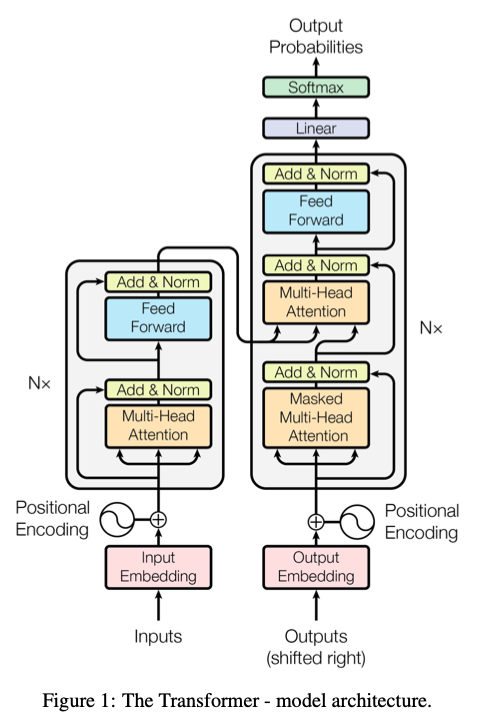

## 2. Setup

Let's set up our environment!  We will be using tensorflow Keras layers to build our encoder.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

## 3. Set-up Configuration

We need to configure our model's attributes.



In [2]:
@dataclass
class Config:
    MAX_LEN = 256   # input dimension
    BATCH_SIZE = 32   # sample size
    LR = 0.001    # learning rate
    VOCAB_SIZE = 30000    # vocabulary size
    EMBED_DIM = 128   # embedding dimension
    NUM_HEAD = 8  # attention layer
    FF_DIM = 128  # ff layer 

config = Config()

## 3. Load the data

We will first download the IMDB data.

In [3]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.2M      0  0:00:07  0:00:07 --:--:-- 18.2M


## 4. Create the dataframe (pandas)

We will put the data into the pandas dataframe. It should look like this.



```
#                                                   review  sentiment
# 0      This movie is so bad, it's comical. In fact, M...          1
# 1      I saw this film at the Toronto International F...          0
# 2      This was no Trainspotting or Guy Ritchie film....          1
# 3      There is great detail in A Bug's Life. Everyth...          0
# 4      I don't think I'm too far off base saying that...          1

```



In [4]:
def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
                # print(line)
    return text_list


def get_data_from_text_files(folder_name):

    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)
    print(pos_texts)
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)
    
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )
    df = df.sample(len(df)).reset_index(drop=True)
    return df


train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = train_df.append(test_df)

print(all_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                                                  review  sentiment
0      Way back in 1967, a certain director had no id...          1
1      This may not be a memorable classic, but it is...          0
2      After a long hard week behind the desk making ...          0
3      I don't understand. Not being a critic, i am n...          0
4      This hard-hitting, often violent western in th...          0
...                                                  ...        ...
24995  This film would be considered controversial to...          0
24996  After some internet surfing, I found the "Home...          1
24997  When I first saw this movie in the theater I w...          1
24998  This movie was quite a pleasant surprise. I ha...          0
24999  I rented this film from Blockbust because of t...          1

[50000 rows x 2 columns]


## 5. Data pre-processing

We know that we cannot give words into our neural network but only numbers, vectors or matrices, so we need to turn our text into token ids before feeding it into the network.


1. We will use the `TextVectorization` Keras layer to vectorize the text.

2.  The `mask_input` function will mask some of input token ids for training. 15% of all input tokens in each sequence will be masked at random.

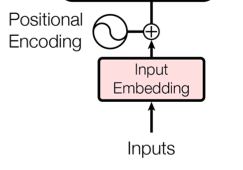


## 6. Build the vectorization layer

We will create a vectorization layer and initiate it with the text data we have to get all the words as a vocabulary and their indices.

This layer analyzes the dataset, determine the frequency of individual string values, and create a vocabulary from them.

In [5]:
def normalize_text(input_data):

    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )

    
def build_vectorization_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):

    # Create the vectorization layer.
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=normalize_text,
        output_sequence_length=max_seq,
    )

    # Call `adapt` on the text-only dataset to create the vocabulary.
    # Compute a vocabulary of string terms from tokens in a dataset.
    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary.
    vocab = vectorize_layer.get_vocabulary()

    print(vocab[:10])
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    print(vocab[:10])
    vectorize_layer.set_vocabulary(vocab)


    return vectorize_layer

# Initiate the vectorization layer.
vectorize_layer = build_vectorization_layer(
    all_data.review.values.tolist(),    # text data (list)
    config.VOCAB_SIZE,    # VOCAB_SIZE=30000
    config.MAX_LEN,     # MAX_LEN=256
    special_tokens=["[mask]"],
)

# Create a token id for masked tokens as "[mask]".
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]

# mask_token_id = 29999 (the last in the dict)

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']
['the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this']


## 7. Vectorize the training text data

Now we are turning the text data into numbers

* The text data:  

```
[ I loved the plot but hated the main character ]
```
* The vectorized data: **bold text**

```
[  3  145   0   3034   6   345   0   45   1453 ]
```

In [6]:
# We have 25000 examples for training

# print(train_df.review.values)
x_train = vectorize_layer(train_df.review.values).numpy()  # encode reviews with vectorizer
# print(x_train)

# We have 25000 examples for testing
x_test = vectorize_layer(test_df.review.values).numpy()
# print(x_test)

# Prepare data for masked language model
# all data, train + text
x_all_review = vectorize_layer(all_data.review.values).numpy()

## 8. Mask the input

We cannot give the input as it is and expect learning, right!

*   Input: "I have watched this `[MASK]` and it was awesome."
*   Output: "I have watched this movie and it was awesome."

Therefore, we need to use a strategy called **masking** to mask some tokens in the training data and train the neural network by asking to predict these masked tokens. 

In the end, we expect the neural network to look at the context words in order to guess the correct token.

In [7]:
def mask_input(encoded_texts):

    # Create the masking filter with each sequence to masked 15% 
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # print(inp_mask)
    # print('\n')


    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)

    # Mask input
    encoded_texts_masked[inp_mask] = mask_token_id 
    # print(encoded_texts_masked)
    # print('\n')

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)
    # print(y_labels)
    # print('\n')

    return encoded_texts_masked, y_labels


x_masked_train, y_labels = mask_input(
    x_all_review
)

masked_dataset = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_labels)
)

# for i in masked_dataset:
#   print(i)
#   break

masked_dataset = masked_dataset.shuffle(1000).batch(config.BATCH_SIZE) # 32

## 9. Create the Transformer encoder


Up to now, we prepared our dataset for training and it is ready to be fed into the neural network.

But where is our neural network?

What do we need?

* Word embeddings
* Word embeddings + Positional encodings
* Attention layer
* Feed-forward layer
* Softmax layer

We will use keras multi-head attention (`MultiHeadAttention`), embedding (`Embedding`), dropout (`Dropout`) and (`LayerNormalization`) layers

Our final model will get token ids as inputs (including masked tokens) and it will predict the correct ids for the masked input tokens.

## 10. Create the positional encoding matrix

Since the Transformers do not get the text data sequentially, we need to provide the order information into our neural network by using a positional encoding matrix which is created with `MAX_LEN` (`256`) and `EMBED_DIM` (`128`) which we set before.

We get the positional encodings by using sin and cos curves.

In [8]:
def create_positional_encoding_matrix(max_len, d_emb):
    # initialize the encoding matrix
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )

    # get positional encodings by using sin and cos curves
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # (feature) dim 2i (even numbers)
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # (feature) dim 2i+1 (odd numbers)

    return pos_enc

## 11. Build the Transformer encoder block

Now we are here finally!

We will layer up our encoder block.  

* The first layer is our **attention layer**. We will use the keras `MultiHeadAttention` layer for this. It takes `num_heads` (number of attention heads) and `key_dim` (size of each attention head for query and key) arguments.  We also feed `query`, `key` and `value` which are basically the same embeddings we get by adding positional encodings to the input word embeddings.

* **Feed forward layer** consists of two `Dense` keras layers, both with a dimension size of `128` with  a `ReLU` activation in between.

* We also have `LayerNormalization` layers.  Pay attention to the input to these layers!  It is the addition of the input and the output of the same layers for knowledge preservation from previous layers.   

* Finally, there are two `Dropout` layers the function of which is to prevent the model from over-fitting.

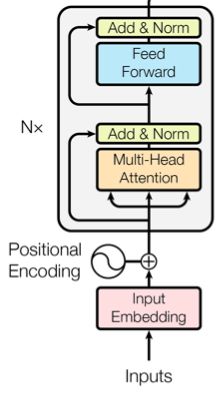
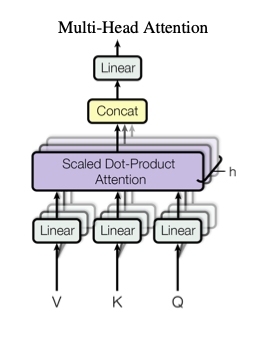


In [9]:
def EncoderBlock(query, key, value):

    # i = layer
    # Multi headed self-attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,  # 8
        key_dim=config.EMBED_DIM // config.NUM_HEAD,  # 128 # 8
        name="encoder/multiheadattention",
    )(query, key, value)

    # Add dropout layer
    attention_output = layers.Dropout(0.1, name="encoder/att_dropout")(
        attention_output
    )

    # Add (knowledge preservation) + Layer normalization
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder/att_layernormalization"
    )(query + attention_output)

    # Feed-forward layer
    # Linear layers with relative activations in between
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"), # 128
            layers.Dense(config.EMBED_DIM),   # 128
        ],
        name="encoder/ffn",
    )

    # Feed the output from the attention layer to the feed forward leyer
    ffn_output = ffn(attention_output)

    # Add dropout layer
    ffn_output = layers.Dropout(0.1, name="encoder/ffn_dropout")(
        ffn_output
    )

    # Add (knowledge preservation) + Layer normalization (makes convergence faster and more stable)
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder/ffn_layernormalization"
    )(attention_output + ffn_output)

    return sequence_output

## 12. Build the final language model architecture 

Now we will combine the layers in order to create the final attention-based model.

The important part in this section is to pay attention wo how we feed each layer. 

In [10]:
def create_masked_language_model():

    # Input layer
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)

    # Embedding layer
    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)

    # Embedding layer (passing positional encodings as weights)
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[create_positional_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))

    # Adding positional encodings to the input embeddings. 
    embeddings = word_embeddings + position_embeddings
    
    # getting the input matrix for Q, K, V
    encoder_input = embeddings

    encoder_output = EncoderBlock(encoder_input, encoder_input, encoder_input)

    # Output the predictions for the masked tokens
    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )

    # Create the model from inputs and outputs
    mlm_model = tf.keras.Model(inputs, mlm_output, name="masked_language_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)

    # Configure the model for training.    
    mlm_model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy', 
                      metrics=["accuracy"])
    
    return mlm_model

In [11]:
# Initiate the model
bert_masked_model = create_masked_language_model()

# See the model architecture 
bert_masked_model.summary()

Model: "masked_language_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, 256, 128)     3840000     ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 256, 128)    0           ['word_embedding[0][0]']         
 da)                                                                                              
                                                                                                  
 encoder/multiheadattention (Mu  (None, 256, 128)    66048       ['tf.__operat

In [12]:
id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}

class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)

sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())


## 13. Train and Save

Let's train our model!

In [13]:
bert_masked_model.fit(masked_dataset, epochs=5, callbacks=[generator_callback])
bert_masked_model.save("masked_language_model_imdb.h5")

Epoch 1/5
1/1 [==============================] - 0s 181ms/step
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'of',
 'prediction': 'i have watched this of and it was awesome',
 'probability': 0.04205581}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'and',
 'prediction': 'i have watched this and and it was awesome',
 'probability': 0.03511478}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'a',
 'prediction': 'i have watched this a and it was awesome',
 'probability': 0.031839732}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'to',
 'prediction': 'i have watched this to and it was awesome',
 'probability': 0.030562572}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'is',
 'prediction': 'i have watched this is and it was awesome',
 'probability': 0.027627127}
1563/1563 [========

## 14. Fine-tune a sentiment classification model

We will fine-tune our self-supervised model on a downstream task of sentiment classification.
To do this, let's create a classifier by adding a pooling layer and a `Dense` layer on top of the
pretrained BERT features.

In [17]:
# Load pretrained bert model
mlm_model = keras.models.load_model("masked_language_model_imdb.h5")
pretrained_bert_model = tf.keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder/ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False


def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)
    sequence_output = pretrained_bert_model(inputs)
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)
    classifer_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.Adam()
    classifer_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return classifer_model


classifer_model = create_classifier_bert_model()
classifer_model.summary()


# We have 25000 examples for training
x_train = vectorize_layer(train_df.review.values).numpy()  # encode reviews with vectorizer
y_train = train_df.sentiment.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# We have 25000 examples for testing
x_test = vectorize_layer(test_df.review.values).numpy()
y_test = test_df.sentiment.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)

# Build dataset for end to end model input (will be used at the end)
test_raw_classifier_ds = tf.data.Dataset.from_tensor_slices(
    (test_df.review.values, y_test)
).batch(config.BATCH_SIZE)


# Train the classifier with frozen BERT stage
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

# Unfreeze the BERT model for fine-tuning
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 model (Functional)          (None, 256, 128)          3939584   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,947,905
Trainable params: 8,321
Non-trainable params: 3,939,584
______________________________________

## 15. Create an end-to-end model and evaluate it

When you want to deploy a model, it's best if it already includes its preprocessing
pipeline, so that you don't have to reimplement the preprocessing logic in your
production environment. Let's create an end-to-end model that incorporates
the `TextVectorization` layer, and let's evaluate. Our model will accept raw strings
as input.

In [18]:
def get_end_to_end(model):
    inputs_string = keras.Input(shape=(1,), dtype="string")
    indices = vectorize_layer(inputs_string)
    outputs = model(indices)
    end_to_end_model = keras.Model(inputs_string, outputs, name="end_to_end_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    end_to_end_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return end_to_end_model


end_to_end_classification_model = get_end_to_end(classifer_model)
end_to_end_classification_model.evaluate(test_raw_classifier_ds)

782/782 [==============================] - 8s 9ms/step - loss: 0.7364 - accuracy: 0.8202


[0.7363778948783875, 0.8202400207519531]